# My awesome LLM-Application **Reputatio AI**

###Setup
First, make the necessary imports.
Note that further imports may have to be made in addition to the ones below, if your application uses additional fetures such as loaders and tools. You can find the code for these imports in the respective sections of the tutorial notebooks.

In [77]:
!pip install -q langchain langchain-community langchain-core langchain-openai langchain-huggingface langchain-google-genai reportlab
from google.colab import userdata
from langchain_core.runnables import RunnableSequence, RunnableLambda
from langchain_core.prompts import PromptTemplate
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
import os
import pprint
import getpass
import requests
import IPython.display as ipd
from PIL import Image as PILImage
import urllib.request
import re
import matplotlib.pyplot as plt
import base64
from openai import OpenAI
from reportlab.lib.pagesizes import A4
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, PageBreak
from reportlab.platypus import Image as RLImage
from IPython.display import Image as IPyImage, display, Markdown
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import cm
from reportlab.lib import colors
from reportlab.platypus.flowables import HRFlowable
from datetime import datetime


Then, assign the API keys to be able to use OpenAI, Google Serper, Huggingface, etc.

When working with sensitive information like API keys or passwords in Google Colab, it's crucial to handle data securely. As you learnt in the tutorial session, two common approaches for this are using **Colab's Secrets Manager**, which stores and retrieves secrets without exposing them in the notebook, and `getpass`, a Python function that securely prompts users to input secrets during runtime without showing them. Both methods help ensure your sensitive data remains protected.

In [78]:
# **********************************************************************************************
# *                                                                                            *
# *   ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  *
# *                                                                                            *
# *                                      R E P U T A T I O   A I                                 *
# *                                                                                            *
# *                     Multi-AI perception analysis enriched with public web data              *
# *                                                                                            *
# *                                                                                            *
# *   What this notebook does                                                                   *
# *   ----------------------------------------------------------------------------------------  *
# *   • Builds a fact sheet from publicly available online information                          *
# *   • Analyzes how different AI models perceive the same entity                               *
# *   • Create a Matplot diagram from the sentiment ranking                                     *
# *   • Enhances the diagram with imgAI                                                        *
# *   • Provides a PDF report                                                                  *
# *                                                                                            *
# *   Built & maintained by                                                                     *
# *   ----------------------------------------------------------------------------------------  *
# *   Christian Schmid                                                                          *
# *                                                                                            *
# *                                                                                            *
# *                                                                                            *
# *   ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★ *
# *                                                                                            *
# **********************************************************************************************



#API Key Imports
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["SERPER_API_KEY"] = userdata.get('SERPER_API_KEY')
os.environ["GEMINI_API_KEY"] = userdata.get('GEMINI_API_KEY')
os.environ["OPENROUTER_API_KEY"] = userdata.get("OPENROUTER_API_KEY")


# G L O B A L  V A R S
search = GoogleSerperAPIWrapper()
results = {}
sentiment_results = {}
client = OpenAI()

llmOpenAI = ChatOpenAI(model="gpt-5-mini")
llmGemini = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

#Openrouter API for free access on a deepseek Model as our 3rd LLM
llmDeepSeek = ChatOpenAI(
    model="deepseek/deepseek-v3.2",
    base_url="https://openrouter.ai/api/v1",
    api_key=os.environ["OPENROUTER_API_KEY"],
)

#dict for storing 1:n LLMs
llms = {
    "openai": llmOpenAI,
    "gemini": llmGemini,
    "deepseek": llmDeepSeek
}

####User Input
The user is expected to provide a company name via the chat interface. As this interface is not available in the current notebook, an example company name is stored in a variable instead.

This value can be adjusted either directly here or at the very end of the notebook, where the complete processing chain is invoked.

In [81]:
user_input = "Georg Fischer AG"

###Prompt Templates

In [82]:

#Template to feed the different AI models
analyze_prompt_template = PromptTemplate(
    input_variables=["company"],
    template = ("""Based on the company name provided: {company}, generate a concise company profile and assessment.
                Include:
                - A brief description of what the company does
                - Its primary industry and general market positioning
                - Perceived strengths and weaknesses
                - Overall reputation and maturity level

                Rules:
                - Use only widely known, high-level information
                - Do not speculate or invent facts
                - Explicitly state uncertainty where information is unclear or unavailable
                - Use a neutral, analytical tone
                - Maximum length: 150–200 words
                - Return a result, and do not dodge the task"""
               )
)

#Template for one of the AI (in my case openAI) to analyze the sentiment of the results from the AI models
sentiment_prompt_template = PromptTemplate(
    input_variables=["company_analysis_sentiment"],
    template = ("""You are analyzing the output of an AI-generated company assessment.
                Input text:
                {company_analysis_sentiment}

                Your task:
                - Determine whether the overall sentiment of the text is predominantly positive, neutral, or negative
                - Explain briefly why this sentiment classification applies, referring only to the content of the text
                - Provide a sentiment rating on a scale from 1 to 5, where:
                  1 = very negative
                  2 = mostly negative
                  3 = neutral or balanced
                  4 = mostly positive
                  5 = very positive

                Rules:
                - Do not introduce new information or external knowledge
                - Base your evaluation strictly on tone, wording, and emphasis in the provided text
                - If the sentiment is mixed, explain which aspects pull it in each direction
                - Keep the total response under 120 words
                - Use a neutral, analytical tone
                - Return a result, and do not dodge the task
                - Return your result ONLY in exactly this format (3 lines, nothing else):
                  Sentiment: <positive|neutral|negative>
                  Rating: <1|2|3|4|5>
                  Rationale: <sentence>
                - No additional text, no blank lines, no punctuation after the numbers
                - Rating must be a single integer 1–5 (not "4/5", not "3 (neutral)", not "4/5 (mostly positive)")
                - Each field MUST start on a new line

                Example output:
                  Sentiment: neutral
                  Rating: 3
                  Rationale: The text is balanced and emphasizes uncertainty more than praise or criticism."""
               )
)


#Template for enhancing the diagram
image_pimp_prompt_template = PromptTemplate(
    input_variables = [],
    template = ("""You are a professional infographic designer.

              You are given an existing bar chart image that visualizes sentiment ratings.
              Your task is to RESTYLE the image for visual quality only.

              STRICT RULES (must be followed exactly):
              - Do NOT change bar heights, proportions, or positions
              - Do NOT change numeric values, labels, or axis scales
              - Do NOT add or remove data
              - Do NOT reinterpret the chart or redraw it differently
              - Preserve the exact structure and meaning of the original chart

              ALLOWED ENHANCEMENTS:
              - Improve color palette (professional, modern)
              - Add subtle gradients or soft shadows
              - Improve typography clarity and alignment
              - Slightly round bar edges
              - Clean, neutral background
              - Improve spacing and visual balance

              STYLE:
              - Clean corporate infographic
              - Flat design with subtle depth
              - High contrast but restrained colors
              - Suitable for an executive PDF report
              - No decorative icons or illustrations

              OUTPUT:
              - The background should be dark grey
              - Each bar is glowing and has a different color
              - A visually enhanced version of the same chart
              - Data accuracy must be preserved exactly"""
            )
)

#Template for PDF report creation
pdfreport_prompt_template = PromptTemplate(
    input_variables=[
      "company_results",
      "sentiment_results",
      "sentiment_diagram"
      ],
    template = ("""You are creating a structured analytical report intended for export as a PDF.

                Input data:
                1) Company analysis results from multiple AI models:
                {company_results}

                2) Sentiment analysis of these results:
                {sentiment_results}

                3) Sentiment comparison diagram (Mermaid):
                {sentiment_diagram}

                Your task:
                Create a well-structured report with the following sections:

                1. Executive Summary
                  - High-level overview of the company
                  - Key themes consistently mentioned across AI models

                2. Company Analysis (AI Model Perspectives)
                  - Summarize the main observations from each model
                  - Highlight common strengths, weaknesses, and uncertainties
                  - Keep the tone neutral and analytical

                3. Sentiment Analysis
                  - Explain how each model's output was evaluated
                  - Compare sentiment classifications and ratings
                  - Briefly interpret similarities and differences

                4. Sentiment Comparison Visualization
                  - Introduce the diagram
                  - Explain what it shows and how to read it
                  - Embed the provided diagram as-is

                5. Overall Conclusion
                  - Summarize how the company is perceived across models
                  - Comment on overall sentiment balance and confidence level

                Formatting rules:
                - Use clear headings and subheadings
                - Write in professional report language
                - Avoid speculation or new information
                - Ensure the text is suitable for direct PDF export
                - Do not reference prompts or AI instructions"""
               )
)

###Websearch Chain

In [83]:
#Recent web search for the company using Google Serper - used as additional input for LLM
def serper_company_search(company_name, num_results=5):
    url = "https://google.serper.dev/search"
    headers = {
        "X-API-KEY": os.environ.get("SERPER_API_KEY"),
        "Content-Type": "application/json",
    }
    payload = {
        "q": company_name,
        "num": num_results,
    }

    try:
        response = requests.post(url, headers=headers, json=payload, timeout=10)
        response.raise_for_status()
        data = response.json()

        snippets = []
        for item in data.get("organic", []):
            title = item.get("title", "")
            snippet = item.get("snippet", "")
            if snippet:
                snippets.append(f"- {title}: {snippet}")

        if not snippets:
            return "No relevant web information found."

        return "Recent publicly available web context:\n" + "\n".join(snippets[:num_results])

    except Exception as e:
        return f"Web search unavailable due to error: {e}"



#Calling the function + show results in markdown (optional / just a quick control/checkpoint)
web_context = serper_company_search(user_input)
display(Markdown(f"### Serper Web Search Result\n\n{web_context}"))


### Serper Web Search Result

Recent publicly available web context:
- Georg Fischer: Georg Fischer: worldwide preferred partner for the safe transport of liquids and gases, vehicle weight reduction and high-precision manufacturing ...
- Georg Fischer (company) - Wikipedia: Founded in 1802, the corporation is headquartered in Switzerland and is present in 45 countries, with 187 companies, 76 of them production facilities.
- Georg Fischer AG (GF.SW) Stock Price, News, Quote & History: Georg Fischer AG engages in the provision of piping systems, and casting and machining solutions in Europe, the Americas, Asia, and internationally.
- Company Georg Fischer AG - MarketScreener: Georg Fischer AG is a Switzerland-based company engaged in the development of systems for industrial applications.
- Annual Report 2024 - Georg Fischer Ltd: The Annual Report 2024 consists of the Management Review, Sustainability Statement, Corporate Governance Report, Compensation Report and Financial Report.

###Analyze Company Chain




In [84]:
#Function to invoke the different LLMs to gather info about the company, include search results as additional context
def analyze_company(llms, user_input):

    #Invoke the search
    web_context = serper_company_search(user_input)

    #Loop through all LLMs and store their response in a dictionary
    for name, llm in llms.items():
        prompt = analyze_prompt_template.format(company=user_input, web_context=web_context)
        response = llm.invoke(prompt)
        content = response.content if hasattr(response, "content") else str(response)
        results[name] = content

    return results


#Call the function and store the output in results
results = analyze_company(llms, user_input)

#Show the results in markdown (optional / just for a quick control/checkpoint)
for name, text in results.items():
    display(Markdown(f"## {name.upper()} perception"))
    display(Markdown(text))


## OPENAI perception

Georg Fischer AG is a Swiss industrial engineering and manufacturing group supplying piping systems, machining solutions and casting components to infrastructure, transportation and general industry customers. Founded in 1802, it operates globally through business divisions that serve water, gas, automotive and industrial manufacturing markets.

Primary industry and positioning: industrial manufacturing/engineering. Georg Fischer is positioned as a diversified, mid-to-large‑cap Swiss supplier of engineered components and systems, focused on B2B infrastructure and OEM markets rather than consumer products.

Perceived strengths: long history and engineering expertise; diversified product portfolio across piping, machining and casting; global footprint and established OEM and infrastructure customer relationships. Perceived weaknesses: exposure to cyclical end markets (construction, automotive, manufacturing); competitive pressure from larger industrial groups and specialized suppliers; sensitivity to macroeconomic and commodity swings. Specific current financials, market share and recent strategic initiatives are not provided here and would be needed for a more detailed assessment.

Overall reputation and maturity level: a mature, reputable industrial group with a long track record in precision engineering and infrastructure components.

## GEMINI perception

Based solely on the company name "Georg Fischer AG":

**Description & Primary Industry:**
The specific business activities and primary industry of Georg Fischer AG cannot be determined from its name alone. It is unknown what products or services the company provides or which sectors it operates within.

**General Market Positioning:**
Without knowledge of its industry or operations, its market positioning (e.g., leader, niche player, mass market) cannot be assessed.

**Perceived Strengths & Weaknesses:**
Specific strengths and weaknesses are unknown as the company's business model, competitive landscape, and operational performance are not discernible from its name.

**Overall Reputation & Maturity Level:**
The "AG" (Aktiengesellschaft) designation indicates a public limited company, common in German-speaking countries. This structure, combined with a founder's name ("Georg Fischer"), strongly suggests an established and mature organization, likely with a significant history. However, its specific reputation within any given industry or among stakeholders is unknown and cannot be inferred.

## DEEPSEEK perception

**Company Profile: Georg Fischer AG**

Georg Fischer AG (GF) is a Swiss industrial manufacturing group operating primarily in three core segments: **GF Piping Systems** (plastic and metal flow solutions), **GF Casting Solutions** (lightweight casting components for automotive and industrial sectors), and **GF Machining Solutions** (precision machining equipment, especially for the tool and die industry).

**Industry & Positioning:** It is a **global supplier** in industrial manufacturing, known as a niche leader in piping systems and precision components. Its market positioning is typically that of a specialized, high-quality solutions provider rather than a mass-market competitor.

**Perceived Strengths & Weaknesses:** Strengths include a long history (founded 1802), engineering expertise, and diversified industrial portfolio providing stability. A key weakness is its exposure to cyclical end-markets like automotive and general industrial investment, making it susceptible to economic downturns. Its exact financial performance metrics relative to specific peers are unclear from high-level information.

**Reputation & Maturity:** GF has a **solid reputation** for reliability and quality in its core fields and is considered a mature, established industrial player. It operates at a large scale globally but is not typically ranked among the very largest industrial conglomerates.

###Sentiment Chain

In [85]:
#Function to analyze the sentiment of the provided results
def analyze_sentiment(results, llm):

    for model_name, company_text in results.items():
        prompt = sentiment_prompt_template.format(
            company_analysis_sentiment=company_text
        )

        response = llm.invoke(prompt)
        content = response.content if hasattr(response, "content") else str(response)

        sentiment_results[model_name] = content

    return sentiment_results

#Call the function and store the output in sentiments (only 1 LLM needed - I chose openAI)
sentiments = analyze_sentiment(results, llmOpenAI)


#Show the results in markdown (optional / just for a quick control/checkpoint)
for model_name, sentiment_text in sentiments.items():
    display(
        Markdown(
            f"## {model_name.upper()} – Sentiment Evaluation\n\n{sentiment_text}"
        )
    )


## OPENAI – Sentiment Evaluation

Sentiment: positive
Rating: 4
Rationale: The text highlights long history, engineering expertise, diversification, global footprint and strong reputation, while also acknowledging cyclical exposures, competition and missing financial specifics, so overall tone is mostly positive.

## GEMINI – Sentiment Evaluation

Sentiment: neutral
Rating: 3
Rationale: The text is predominantly neutral, emphasizing lack of information and uncertainty while briefly noting a slightly positive indication of maturity from the "AG" designation.

## DEEPSEEK – Sentiment Evaluation

Sentiment: positive
Rating: 4
Rationale: The profile highlights long history, engineering expertise, niche leadership and a solid reputation, while noting cyclical exposure and unclear financials, producing an overall mostly positive tone.

Diagram Chain

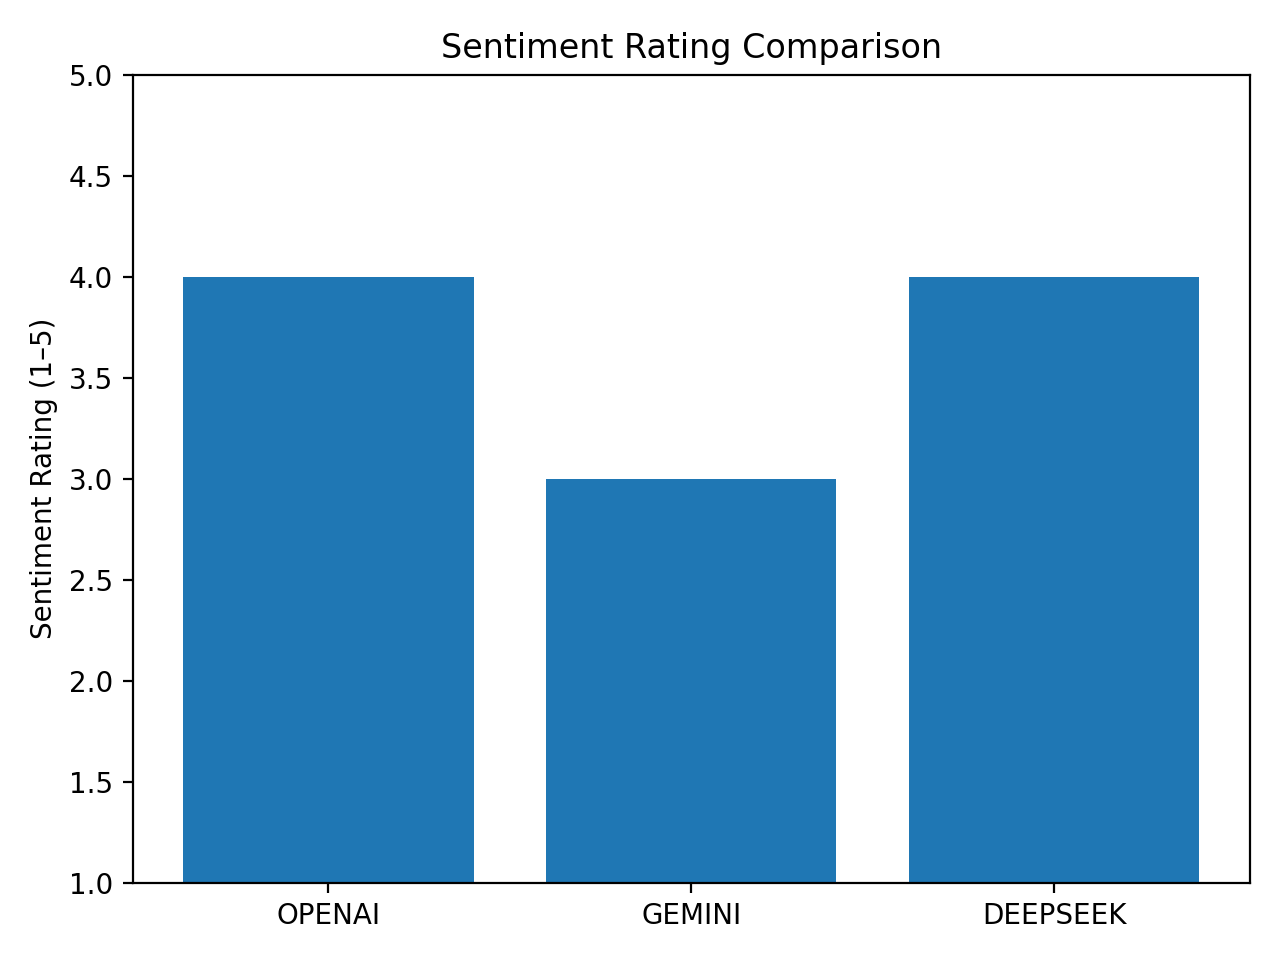

Saved: sentiment_comparison.png


In [86]:
#Function to create a PNG bar chart based on the sentiment rating with Python matplotlib library
def save_sentiment_chart_png(sentiments, filename="sentiment_comparison.png", title="Sentiment Rating Comparison"):

    models = []
    ratings = []

    for model_name, text in sentiments.items():
        m = re.search(r"Rating:\s*([1-5])\b", str(text))
        if not m:
            raise ValueError(f"Could not find a valid 'Rating: 1-5' for model '{model_name}'. Text was:\n{text}")
        models.append(model_name.upper())
        ratings.append(int(m.group(1)))

    plt.figure()
    plt.bar(models, ratings)
    plt.ylim(1, 5)
    plt.ylabel("Sentiment Rating (1–5)")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename, dpi=200)
    plt.close()

    display(Image(filename=filename))
    return filename

png_path = save_sentiment_chart_png(sentiments, filename="sentiment_comparison.png")
print("Saved:", png_path)



DiagramPimp Chain

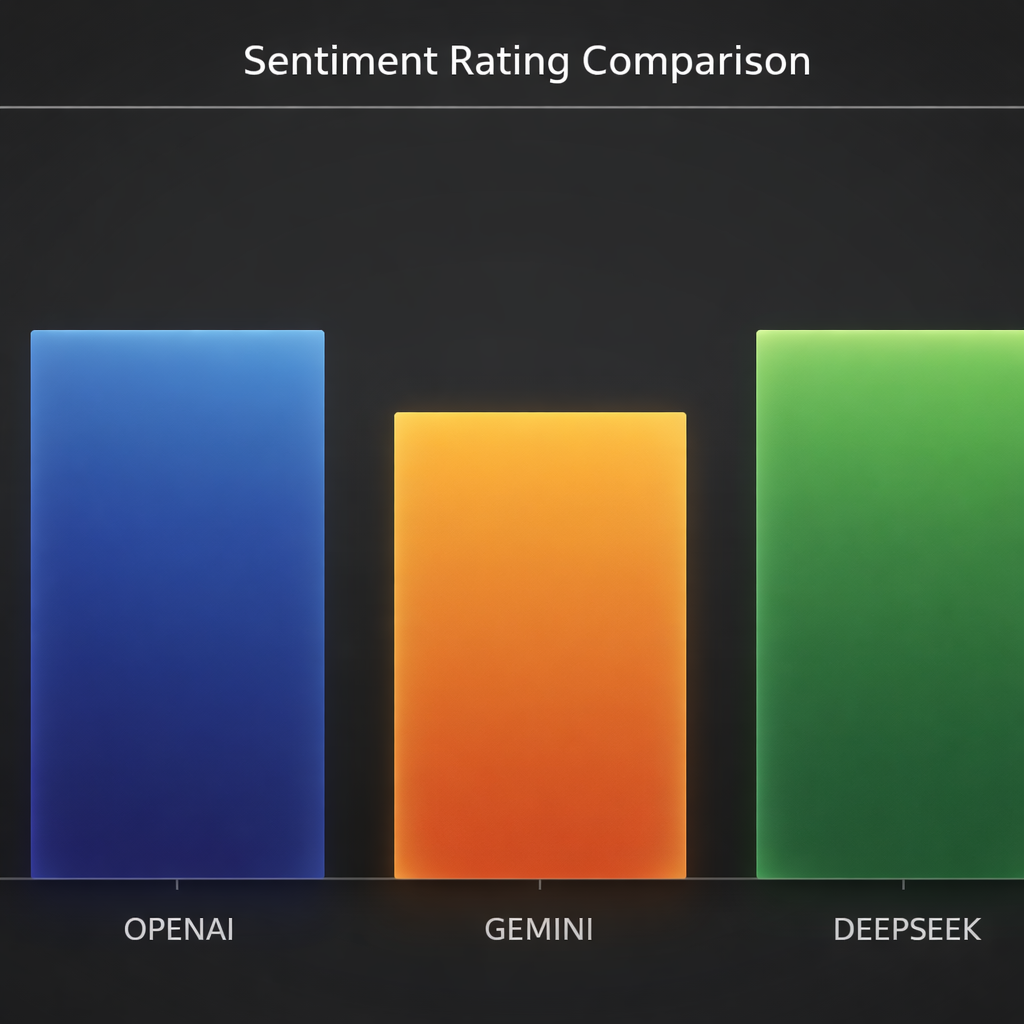

Saved: sentiment_comparison_pimped.png


In [87]:
import base64
from openai import OpenAI
from IPython.display import Image, display

client = OpenAI()

def pimp_sentiment_chart_image_api(
    input_png_path: str,
    output_png_path: str = "sentiment_comparison_pimped.png",
    model: str = "gpt-image-1.5",
):
    # Style from prompt template:
    prompt_text = image_pimp_prompt_template.format()

    # Images API
    with open(input_png_path, "rb") as img_file:
        result = client.images.edit(
            model=model,
            image=img_file,
            prompt=prompt_text,
            output_format="png",
        )

    # GPT Image modell base64
    image_bytes = base64.b64decode(result.data[0].b64_json)
    with open(output_png_path, "wb") as f:
        f.write(image_bytes)

    display(Image(filename=output_png_path))
    return output_png_path


# function call
pimped_chart = pimp_sentiment_chart_image_api(
    input_png_path="sentiment_comparison.png",
    output_png_path="sentiment_comparison_pimped.png"
)
print("Saved:", pimped_chart)



###PDF Report

In [88]:

def export_company_report_pdf(company_name, results, sentiments, chart_png_path,
                              output_pdf_path="company_report.pdf"):

    styles = getSampleStyleSheet()
    title_style = ParagraphStyle(
        "Title",
        parent=styles["Title"],
        fontSize=20,
        leading=24,
        spaceAfter=12
    )
    h1 = ParagraphStyle(
        "H1",
        parent=styles["Heading1"],
        fontSize=14,
        leading=18,
        spaceBefore=12,
        spaceAfter=8
    )
    h2 = ParagraphStyle(
        "H2",
        parent=styles["Heading2"],
        fontSize=12,
        leading=16,
        spaceBefore=10,
        spaceAfter=6
    )
    body = ParagraphStyle(
        "Body",
        parent=styles["BodyText"],
        fontSize=10.5,
        leading=14,
        spaceAfter=8
    )
    mono = ParagraphStyle(
        "Mono",
        parent=styles["BodyText"],
        fontName="Courier",
        fontSize=9.5,
        leading=12,
        textColor=colors.black,
        spaceAfter=8
    )

    doc = SimpleDocTemplate(
        output_pdf_path,
        pagesize=A4,
        leftMargin=2*cm,
        rightMargin=2*cm,
        topMargin=2*cm,
        bottomMargin=2*cm
    )

    story = []

    # ---- Cover / Header
    story.append(Paragraph("Company Perception Report", title_style))
    story.append(Paragraph(f"<b>Company:</b> {company_name}", body))
    story.append(Paragraph(f"<b>Generated:</b> {datetime.now().strftime('%Y-%m-%d %H:%M')}", body))
    story.append(Spacer(1, 8))
    story.append(HRFlowable(width="100%", thickness=1, color=colors.grey))
    story.append(Spacer(1, 12))

    # ---- Section: Company analyses
    story.append(Paragraph("1. Company Analysis (Model Outputs)", h1))
    story.append(Paragraph(
        "Below are the raw company assessments produced by each model.", body
    ))

    for model_name, text in results.items():
        story.append(Paragraph(model_name.upper(), h2))
        # Keep formatting simple: convert newlines to <br/>
        safe_text = (text or "").replace("&", "&amp;").replace("<", "&lt;").replace(">", "&gt;")
        safe_text = safe_text.replace("\n", "<br/>")
        story.append(Paragraph(safe_text, body))
        story.append(Spacer(1, 6))

    story.append(PageBreak())

    # ---- Section: Sentiment analyses
    story.append(Paragraph("2. Sentiment Evaluation (Single Evaluator Model)", h1))
    story.append(Paragraph(
        "Below are the sentiment classifications and ratings applied to each model output.",
        body
    ))

    for model_name, s_text in sentiments.items():
        story.append(Paragraph(model_name.upper(), h2))
        # sentiment outputs are short; mono looks nice and keeps line breaks
        s_safe = (s_text or "").replace("&", "&amp;").replace("<", "&lt;").replace(">", "&gt;")
        story.append(Paragraph("<br/>".join(s_safe.splitlines()), mono))
        story.append(Spacer(1, 6))

    story.append(PageBreak())

    # ---- Section: Chart
    story.append(Paragraph("3. Sentiment Rating Comparison Chart", h1))
    story.append(Paragraph(
        "The chart below visualizes the sentiment ratings (1-5) across model outputs.",
        body
    ))

    if chart_png_path and os.path.exists(chart_png_path):
        img = RLImage(chart_png_path)

        page_width, page_height = A4

        # IMPORTANT: use the actual usable width (margins!) + add a small safety padding
        usable_width = page_width - doc.leftMargin - doc.rightMargin
        max_width = usable_width - 12   # <- 12 points safety buffer
        max_height = page_height * 0.4

        img_width = img.imageWidth
        img_height = img.imageHeight

        scale = min(max_width / img_width, max_height / img_height)

        img.drawWidth = img_width * scale
        img.drawHeight = img_height * scale
        img.hAlign = "CENTER"           # <- centers the image in the frame

        story.append(Spacer(1, 12))
        story.append(img)
    else:
        story.append(Paragraph(
            f"Chart image not found at: {chart_png_path}", body
        ))

    # Build PDF
    doc.build(story)
    return output_pdf_path


#Call the function and generate the pdf report
pdf_path = export_company_report_pdf(
    company_name=user_input,
    results=results,
    sentiments=sentiments,
    chart_png_path="sentiment_comparison_pimped.png",
    output_pdf_path="company_report.pdf"
)

print("PDF saved to:", pdf_path)


PDF saved to: company_report.pdf


###Final Sequential Chain for quick rehersal

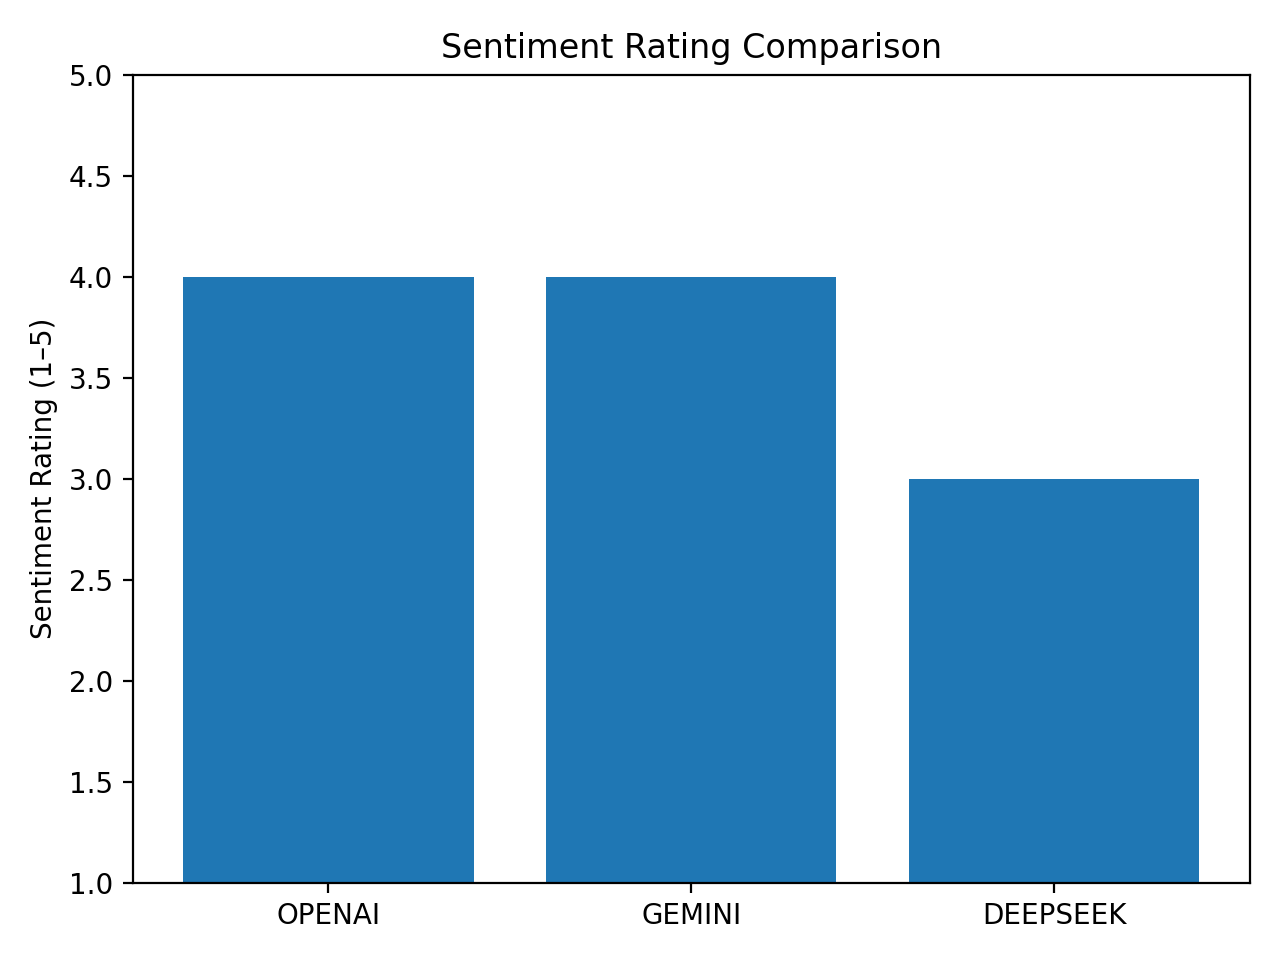

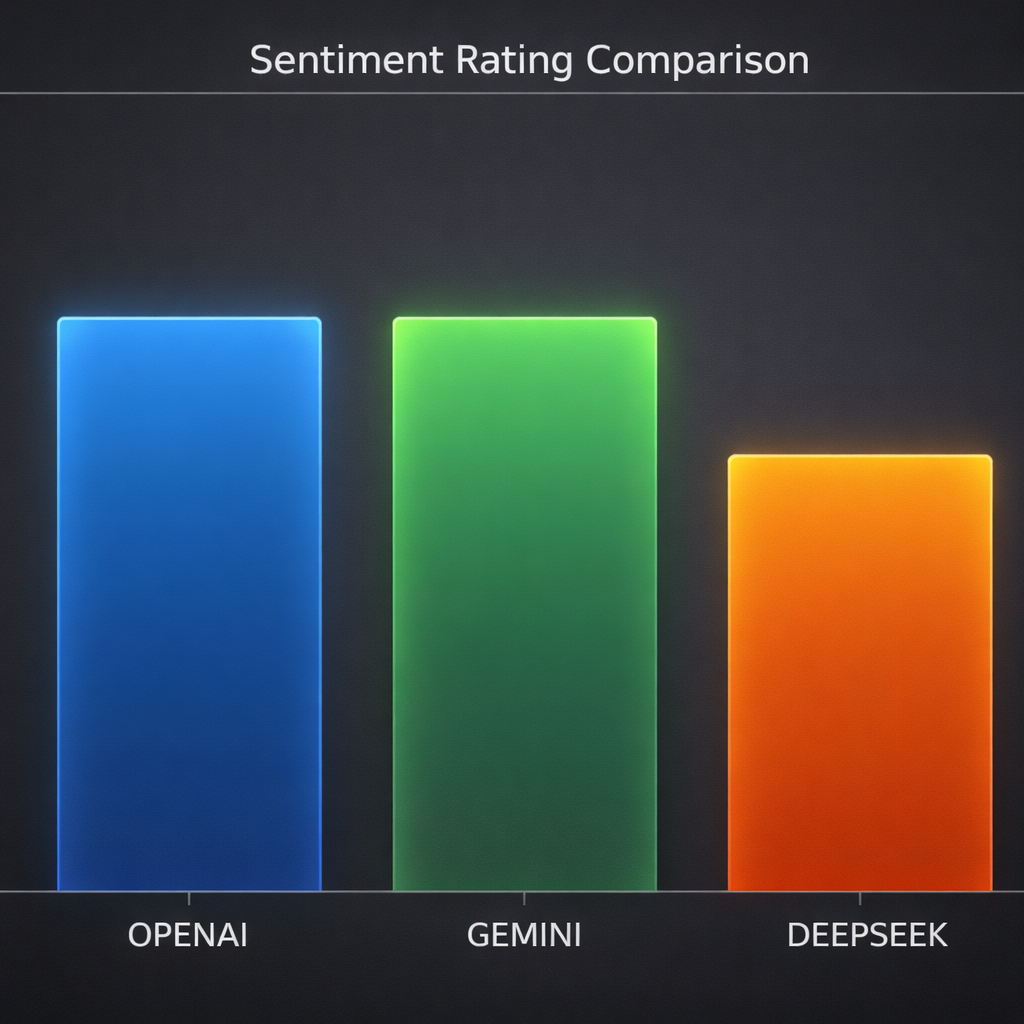

PDF: company_report_Nestle.pdf
Pimped chart: sentiment_comparison_Nestle_pimped.png


In [89]:
#Lets use another example user_input
user_input = "Nestle"


web_search_step = RunnableLambda(
    lambda x: {**x, "web_context": serper_company_search(x["company"])}
)

analysis_step = RunnableLambda(
    lambda x: {
        **x,
        "results": analyze_company(llms, x["company"])
    }
)

sentiment_step = RunnableLambda(
    lambda x: {
        **x,
        "sentiments": analyze_sentiment(x["results"], llmOpenAI)
    }
)

chart_step = RunnableLambda(
    lambda x: {
        **x,
        "chart_png_path": save_sentiment_chart_png(
            x["sentiments"],
            filename=f"sentiment_comparison_{x['company'].replace(' ','_')}.png"
        )
    }
)

pimp_step = RunnableLambda(
    lambda x: {
        **x,
        "pimped_chart_png_path": pimp_sentiment_chart_image_api(
            input_png_path=x["chart_png_path"],
            output_png_path=f"sentiment_comparison_{x['company'].replace(' ','_')}_pimped.png"
        )
    }
)


pdf_step = RunnableLambda(
    lambda x: {
        **x,
        "pdf_path": export_company_report_pdf(
            company_name=x["company"],
            results=x["results"],
            sentiments=x["sentiments"],
            chart_png_path=x["pimped_chart_png_path"],
            output_pdf_path=f"company_report_{x['company'].replace(' ','_')}.pdf"
        )
    }
)

pipeline = RunnableSequence(
    web_search_step,
    analysis_step,
    sentiment_step,
    chart_step,
    pimp_step,
    pdf_step
)

#This invokes our whole pipeline:
out = pipeline.invoke({"company": user_input})

print("PDF:", out["pdf_path"])
print("Pimped chart:", out["pimped_chart_png_path"])
